# Project example

Here I'm going to use the setting of the second part of the project to answer the first part's questions. This will hopefully give you some insight into what is expected as well as help you a bit with both parts. Remember that because the settings are slightly different, the exact responses you see here aren't necessarily applicable to what you've been presented with.

You have been asked to investigate transcriptomic differences between naive B cells of young and old mice to understand how resistance to infection may differ between the age groups. Your staff has performed a thorough computational analysis, which they've forwarded to you so that you can write the report describing your findings. Their results, and space for you to write your summary, are included below.

In [1]:
# import modules
from datascience import *
import numpy as np
import random
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import scipy.stats
import pandas as pd
import sklearn
import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from collections import Counter

### Sample collection

#### What breakdown of samples do you propose we collect? (I.e., number of young/old, what experimental protocol to use, etc)

#### We are being asked to investigate the transcriptomic differences between naive B cells from young and old mice. Consequently, we should collect populations of naive B cells from both old (24m) and young (3m) mice. Ideally we will have a roughly balanced number of cells in each cohort. Within each age group, we should collect cells from multiple mice as this will help us investigate heterogeneity and ensure that we can disentangle individual-specific effects from those which are age-related. Having collected these cells, we should perform scRNA-seq in order to quantify transcript abundances. Due to the frequency of X-linked immunity genes, gender is a possible confounder, and for the time being we should select one gender only.

In [2]:
# Load data
sc_meta = pd.read_csv('marrow_naive_B_meta.csv', index_col = 0)
sc_data = pd.read_csv('marrow_naive_B_exp.csv', index_col = 0)
sc_meta.head()

,cell_ontology_class,mouse.id,sex,age
cell,,,,
A10_B002327,naive B cell,24_59_M,male,24m
A11_B002327,naive B cell,24_59_M,male,24m
A13_B002327,naive B cell,24_59_M,male,24m
A15_B002327,naive B cell,24_59_M,male,24m
A17_B002327,naive B cell,24_59_M,male,24m


## Data preparation

#### What steps do you think are necessary to prepare the data for downstream analyses?

#### We need to normalize, remove low-quality genes, and perhaps remove low-quality cells. First we can look at histograms of average gene expression after log tranforming our data. This reveals many genes which we can easily discard because they don't contain much information. We could also compute statistics like the coefficient of variation if we so desired. Going back to the raw counts, we'll next want to normalize using total counts normalization because scRNA-seq data is sparse and thus the median of gene expression in cells can be very noisy. Finally, we log transform and standardize our data so that we can identify outliers using PCA and/or t-SNE.

In [3]:
Counter(sc_meta.age), Counter(sc_meta.sex), Counter(sc_meta.cell_ontology_class)

(Counter({'24m': 784, '3m': 401}),
 Counter({'male': 1185}),
 Counter({'naive B cell': 1185}))

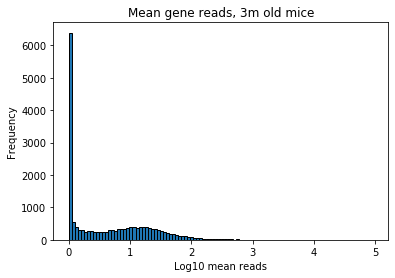

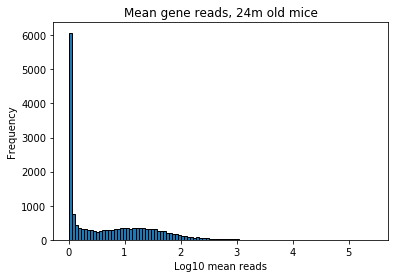

In [4]:
plt.hist(np.log10(np.mean(sc_data.loc[:,sc_meta.age == '3m'], axis = 1)+1), bins = 100)
plt.xlabel('Log10 mean reads')
plt.ylabel('Frequency')
plt.title('Mean gene reads, 3m old mice')
plt.show()
plt.hist(np.log10(np.mean(sc_data.loc[:,sc_meta.age == '24m'], axis = 1)+1), bins = 100)
plt.xlabel('Log10 mean reads')
plt.ylabel('Frequency')
plt.title('Mean gene reads, 24m old mice')
plt.show()

In [5]:
genes_to_keep = (np.log10(np.mean(sc_data.loc[:,sc_meta.age == '3m'], axis = 1)+1) > 1) | (np.log10(np.mean(sc_data.loc[:,sc_meta.age == '24m'], axis = 1)+1) > 1)
exp_sub = sc_data.loc[genes_to_keep,:]

sc_total_med = exp_sub.sum().median()
sc_data_norm = exp_sub / exp_sub.sum() * sc_total_med

## Exploratory data analysis

#### What preliminary and exploratory analyses would you perform? What figures would you generate?

#### We should produce PCA and t-SNE plots to see whether our cells separate, and if they do, the number of clusters which seem to appear. This will be informative for our differential expression analysis and when trying to determine whether there are cellular subtypes present. We should color these plots by age as well as other covariates to help determine the dominant contributors of variation. In this case, we'll want to do age as well as individual. Additional figures which would be helpful are histograms of fold changes and a scatterplot of mean (or median) expression levels in the two conditions. These will display the degree of similarity between the age groups.

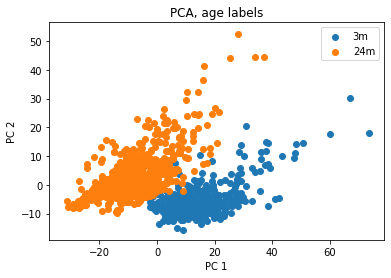

In [6]:
# EDA
x = StandardScaler().fit_transform(np.log2(sc_data_norm.T+1))
pca = PCA(n_components = 100)
principalComponents = pca.fit_transform(x)

plt.scatter(principalComponents[sc_meta['age'] == '3m',0], principalComponents[sc_meta['age'] == '3m',1])
plt.scatter(principalComponents[sc_meta['age'] == '24m',0], principalComponents[sc_meta['age'] == '24m',1])
plt.legend(['3m', '24m'])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA, age labels')
plt.show()

In [7]:
tsne = TSNE(n_components = 2)
X_embedded = tsne.fit_transform(principalComponents)

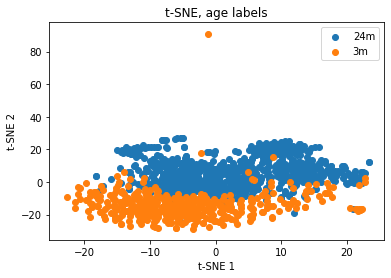

In [8]:
ages = np.unique(sc_meta['age'])
for x in ages:
    plt.scatter(X_embedded[sc_meta['age'] == x,0], X_embedded[sc_meta['age'] == x,1])
plt.legend(ages)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE, age labels')
plt.show()

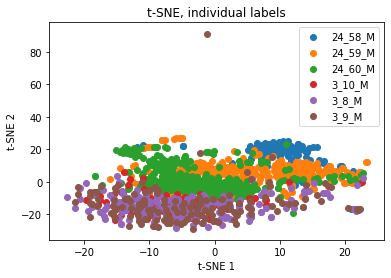

In [9]:
indivs = np.unique(sc_meta['mouse.id'])
for x in indivs:
    plt.scatter(X_embedded[sc_meta['mouse.id'] == x,0], X_embedded[sc_meta['mouse.id'] == x,1])
plt.legend(indivs, bbox_to_anchor = (1,1))
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE, individual labels')
plt.show()

## Differential expression

#### How would you identify whether young/old samples are distinguishable? How would you ascertain which genes, if any, have differences in expression levels associated with age? Be sure to mention the specific analyses and steps you would perform.

#### We'll now want to perform a differential expression analysis to identify the genes which could be driving any differences between these cells. To do this, we should test whether the expression of each gene is different in the two age groups. The best choice for this is probably the rank-sum test, though a permutation (A/B) test is also valid. The t-test is more difficult because of its normality assumption, though it could work if we used log-transformed data. After obtaining p-values, we should verify that they make sense by looking at a histogram of their values as well as a volcano plot to simultaneously visualize fold changes and levels of statistical significance. If everything looks sensible, we'll want to correct the p-values to account for the many tests we've performed (using an FDR correction) to yield corrected p-values. We can then select a cutoff and declare genes falling below this level as differentially expressed. These genes can then be further investigated and flagged for additional study.

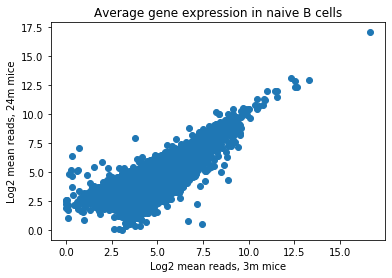

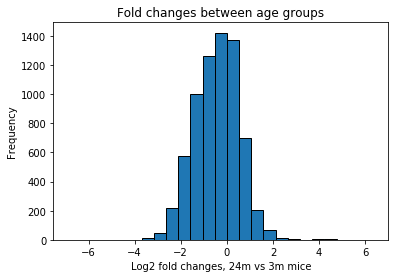

In [10]:
# Differential expression, GO
young_mice = sc_meta['age'] == '3m'
old_mice = sc_meta['age'] == '24m'

young_exp = sc_data_norm.loc[:, young_mice]
old_exp = sc_data_norm.loc[:, old_mice]

plt.scatter(np.log2(np.mean(young_exp, axis = 1)+1), np.log2(np.mean(old_exp, axis = 1)+1))
plt.xlabel('Log2 mean reads, 3m mice')
plt.ylabel('Log2 mean reads, 24m mice')
plt.title('Average gene expression in naive B cells')
plt.show()

log2_fcs = np.log2(np.mean(old_exp, axis = 1)+1) - np.log2(np.mean(young_exp, axis = 1)+1)
plt.hist(log2_fcs, bins = 25)
plt.xlabel('Log2 fold changes, 24m vs 3m mice')
plt.ylabel('Frequency')
plt.title('Fold changes between age groups')
plt.show()

In [ ]:
gene_p_vals = []
for x in np.arange(sc_data_norm.shape[0]):
    p_val = scipy.stats.mannwhitneyu(young_exp.iloc[x,:], old_exp.iloc[x,:], alternative = 'two-sided')[1]
    gene_p_vals.append(p_val)
    
plt.hist(gene_p_vals, bins = 20)
plt.xlabel('p-value')
plt.ylabel('Number of genes')
plt.title('')
plt.show()

# Compute the number of genes which are differentially expressed (p-value less than or equal to 0.05)
q_vector = stats.multitest.multipletests(gene_p_vals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
n_de = sum(q_vector <= 0.05)
n_de

In [ ]:
log_p_vals = -np.log10(gene_p_vals)

plt.scatter(log2_fcs, log_p_vals, alpha=0.2)
plt.xlabel('Log2 FC')
plt.ylabel('-log10(p-value)')
plt.title('Old vs Young, naive B cells')
plt.show()

# Submit

In [1]:
#from client.api.notebook import Notebook

In [2]:
# ok = Notebook('Project02_Report.ok')
# _ = ok.auth(inline=True)

In [1]:
# Submit the assignment.
# _ = ok.submit()